Esta version es para entrenar redes neuronales del sensor de glifosato usando sensor Hammamatsu,
Se usan 100 datos de entrada (50 dispersion+ 50 emision)

In [1]:
#Librerias necesarias para el procesamiento de datos y para la implementacion de las redes neuronales

import math
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import csv
from itertools import islice
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import plotly.express as px
import pandas as pd

In [2]:
!pip install everywhereml>=0.2.12


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\algim\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
#Usar esto para depurar paso a paso

# Aqui abrimos el archivo de las mediciones y realizamos una aumentacion y guardamos los datos aumentados en otro archivo.

file_path= 'sep17v2.csv'

# Initializa listas vacias para guardar datos de entrada y salidas
nombres= []
invalues = []
outvalues = []

# en este arreglo se guardan los datos de las aumentaciones
filaau=["A"] * 110
#aumentaciones= [["A"]*45]
aumentaciones=[]

# Lee el archivo CSV para extraer los primeros 19 valores de cada fila
with open(file_path, 'r') as file:
    reader = csv.reader(file)

    for row in reader:

        name=row[0]
        filaau[1]=row[1]

        #Hace 20-j aumentaciones  , por introduciendo individualmente ruido 2%

        for j in range(1,21):

          filaau[0]=row[0]+"_"+ str(j)

          #Toma 250 valores (corta 38)
          for i in range(3,53):
            filaau[i]=float(row[i])
            filaau[i]=int(filaau[i])
            #Hacer modificacion de valor
            filaau[i]=filaau[i]*random.uniform(0.98, 1.02)
            #Regresar a String
            filaau[i]=str(int(filaau[i]))

          for i in range(54,104):
            filaau[i]=float(row[i])
            filaau[i]=int(filaau[i])
            #Hacer modificacion de valor
            filaau[i]=filaau[i]*random.uniform(0.98, 1.02)
            #Regresar a String
            filaau[i]=str(int(filaau[i]))

          #Guarda aumentacion
          aumentaciones.append(filaau.copy())


        #Hace 20 aumentaciones, mulplicando todo +/- 5%

        for j in range(22,42):

          filaau[0]=row[0]+"_"+ str(j)

          multi1=random.uniform(0.9, 1.1)
          multi2=random.uniform(0.9, 1.1)
          for i in range(3,53):
            filaau[i]=float(row[i])
            filaau[i]=int(filaau[i])
            #Hacer modificacion de valor
            filaau[i]=filaau[i]*multi1
            #Regresar a String
            filaau[i]=str(int(filaau[i]))

          for i in range(54,104):
            filaau[i]=float(row[i])
            filaau[i]=int(filaau[i])
            #Hacer modificacion de valor
            filaau[i]=filaau[i]*multi2
            #Regresar a String
            filaau[i]=str(int(filaau[i]))

          #Guarda aumentacion
          aumentaciones.append(filaau.copy())


        #Hace 20 aumentaciones, sumando todo +/- 10%

        for j in range(23,43):

          filaau[0]=row[0]+"_"+ str(j)

          multi1=random.uniform(0.1, 1)
          multi2=random.uniform(0.1, 1)
          for i in range(3,53):
            filaau[i]=float(row[i])
            filaau[i]=int(filaau[i])
            #Hacer modificacion de valor
            filaau[i]=filaau[i]+(multi1*50)
            #Regresar a String
            filaau[i]=str(int(filaau[i]))

          for i in range(54,104):
            filaau[i]=float(row[i])
            filaau[i]=int(filaau[i])
            #Hacer modificacion de valor
            filaau[i]=filaau[i]+(multi2*50)
            #Regresar a String
            filaau[i]=str(int(filaau[i]))



          #Guarda aumentacion
          aumentaciones.append(filaau.copy())

#Crea archivo CSV
# CSV file path
csv_file_path = 'aumenta.csv'

# Writing to CSV file
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

    # Writing the data to the CSV file
    csv_writer.writerows(aumentaciones)

print(f"CSV file '{csv_file_path}' creado")

CSV file 'aumenta.csv' creado


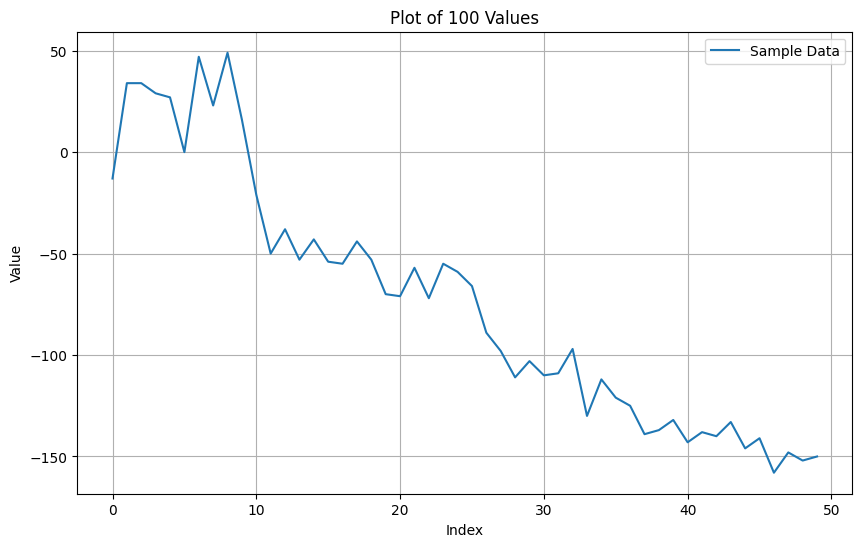

In [4]:
# Grafica un ejemplo de las aumentaciones
# en este arreglo se guardan los datos de las aumentaciones

import matplotlib.pyplot as plt

numdado=350
ploteaesto=[0] * 50   #antes 100

j=0
for i in range(3,53):
  ploteaesto[j]=float(aumentaciones[numdado][i])
  j=j+1


#j=50
#for i in range(54,104):
#  ploteaesto[j]=float(aumentaciones[numdado][i])
#  j=j+1


# Step 2: Plot the values
plt.figure(figsize=(10, 6))
plt.plot(ploteaesto, label='Sample Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of 100 Values')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# En esta funcion se jalan los datos de la tabla aumentada y se establece el modelo a entrenar

# Agregar datos desde la tabla y meter en arreglos numpy

# Se pone el nombre del archivo donde estan los etiquetas-datos, para entrenamiento, validacion y prueba
file_path = 'aumenta.csv'

# Initializa listas vacias para guardar datos de entrada y salidas
nombres= []
invalues = []
outvalues = []

# Lee el archivo CSV para extraer los primeros 250 valores de cada fila
with open(file_path, 'r') as file:
    reader = csv.reader(file)

    for row in reader:

        name=row[0]
        # Convierte los 37 datos en tiplo Float
        row_values1= [float(val) for val in row[3:53]]
        #row_values2= [float(val) for val in row[54:104]]
        salidas= [float(val) for val in row[1:2]]
        #invalues.append(row_values1 + row_values2)
        invalues.append(row_values1)
        outvalues.append(salidas)
        nombres.append(name)

# Convierte las listas en arrays de tipo Numpy
entradas = np.array(invalues)
salidas= np.array(outvalues)
nnombre= np.array(nombres)

entradas_train, entradas_test, salidas_train, salidas_test, nnombre_train, nnombre_test = train_test_split(entradas, salidas, nnombre, test_size=0.1)
entradas_train, entradas_validate, salidas_train, salidas_validate = train_test_split(entradas_train, salidas_train, test_size=0.1)
#nnombre_train, nnombre_test= train_test_split(nnombre, test_size=0.2)

# Crea red neuronal,
model = tf.keras.Sequential()
# Define estructura
# Capa de entrada, 128 neuronas con 100 entradas.
model.add(layers.Dense(64, activation='relu', input_shape=(50,)))        # se quito temperatura
# Capas escondidas 128,64,32 neuronas
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dense(units=8, activation='relu'))

# Capa de salida 1 neurona, activacion linear por que queremos un valor numero que puede variar en un rango amplio.
model.add(layers.Dense(units=1, activation='linear'))
# Compila el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])       #antes mae

In [7]:
# Para visualizar nuestras estructuras de datos de entrenamiento, validacion y prueba
print(entradas_train.shape)
print(entradas_validate.shape)
print(entradas_test.shape)

(2721, 50)
(303, 50)
(336, 50)


In [63]:
#NUNCA COMENZAR DE CERO
model= load_model('jul21.keras')

In [ ]:
#Con esto entreno la red neuronal...

checkpoint = ModelCheckpoint('best_model_weights.keras', monitor='val_mae', save_best_only=True)
history=model.fit(entradas_train, salidas_train, epochs=1000, batch_size=64, validation_data=(entradas_validate, salidas_validate), callbacks=[checkpoint])

model.load_weights('best_model_weights.keras')

print('si acabo')

Epoch 1/10000
32/32 [==============================] - 1s 8ms/step - loss: 197572.8906 - mae: 288.6640 - val_loss: 57625.4258 - val_mae: 193.4660
Epoch 2/10000
32/32 [==============================] - 0s 4ms/step - loss: 55052.2578 - mae: 174.7801 - val_loss: 55219.6406 - val_mae: 187.2217
Epoch 3/10000
32/32 [==============================] - 0s 3ms/step - loss: 51055.0586 - mae: 171.8165 - val_loss: 51272.0781 - val_mae: 172.9693
Epoch 4/10000
32/32 [==============================] - 0s 3ms/step - loss: 49815.1094 - mae: 171.1736 - val_loss: 50151.5156 - val_mae: 173.4996
Epoch 5/10000
32/32 [==============================] - 0s 4ms/step - loss: 48027.7734 - mae: 167.1032 - val_loss: 47471.7695 - val_mae: 166.3191
Epoch 6/10000
32/32 [==============================] - 0s 3ms/step - loss: 45100.7109 - mae: 161.2698 - val_loss: 44337.4258 - val_mae: 161.0708
Epoch 7/10000
32/32 [==============================] - 0s 3ms/step - loss: 41725.4102 - mae: 154.3927 - val_loss: 40767.5664 - va

In [20]:
# Save the model to Google Drive
model.save('sep17.keras')

In [21]:
# En esta funcion se jalan los datos de la tabla original y se hacen predicciones de todas las mediciones

# Agregar datos desde la tabla y meter en arreglos numpy

# Se pone el nombre del archivo donde estan los etiquetas-datos, para entrenamiento, validacion y prueba
file_path = 'sep17v2.csv'

# Initializa listas vacias para guardar datos de entrada y salidas
nombres= []
invalues = []
outvalues = []

# Lee el archivo CSV para extraer los primeros 19 valores de cada fila
with open(file_path, 'r') as file:
    reader = csv.reader(file)

    # Salta la primeras dos filas (por que son encabezado)
    #rows_to_skip = 2
    #for _ in range(rows_to_skip):
    #    next(reader)

    for row in reader:

        name=row[0]
        # Convierte los 37 datos en tiplo Float
        #row_values1= [float(val) for val in row[3:21]]
        #row_values2= [float(val) for val in row[22:41]]    #antes 41, quita temperatura
        row_values1= [float(val) for val in row[3:53]]
        #row_values2= [float(val) for val in row[54:104]]
        salidas= [float(val) for val in row[1:2]]
        invalues.append(row_values1)
        outvalues.append(salidas)
        nombres.append(name)

# Convierte las listas en arrays de tipo Numpy
entradas = np.array(invalues)
salidas= np.array(outvalues)
nnombre= np.array(nombres)

In [22]:
# Hace predicciones de todos los valores, los compara con la medicion y los pone en una tabla CSV.


predicciones= [['Medicion','Concentracion','Prediccion']]

i=0
Conc=0.0
#nombres= []

#Calcula el error promedio
errprom=0
dife=0

for t in entradas:

  inputdata=t
  #name=row[0]
  #inputdata = np.expand_dims(inputdata)
  inputdata = np.expand_dims(inputdata, axis=0)
  preds = model.predict(inputdata)
  Conc=salidas[i][0]
  #predicciones.append([i+1,Conc,preds[0][0]])
  predicciones.append([nnombre[i],Conc,preds[0][0]])
  dife=abs(Conc-preds[0][0])
  errprom=errprom+dife
  i=i+1

#Crea archivo CSV
predicciones.append(["Error promedio",errprom/i," "])


# CSV file path
csv_file_path = 'preds20jul.csv'

# Writing to CSV file
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

    # Writing the data to the CSV file
    csv_writer.writerows(predicciones)

print(f"CSV file '{csv_file_path}' created successfully.")
print("Error promedio",errprom/i," ")

1/1 [==============================] - 0s 18ms/step
CSV file 'preds20jul.csv' created successfully.
Error promedio 0.7846583504052389  


In [23]:
from everywhereml.code_generators.tensorflow import tf_porter

#tf_model, x_train, y_train = get_model()
# tf_porter() requires:
#   1. the neural network model
#   2. the input data (to detect the input dimensions)
#   3. the output labels (to detect the number of classes - if classification)
#
# Passing `instance_name` will create an instance of the model, so you don't have to
# `area_size` is to control how much memory to allocate for the network
# It is a trial-and-error process


#porter = tf_porter(tf_model, entradas_train, salidas_train)
porter = tf_porter(model, entradas_train, salidas_train)
cpp_code = porter.to_cpp(instance_name='glifoNN1', arena_size=10000)

#cpp_code.save('/content/gdrive/My Drive/NNglifosato2/NNmar19')

print(cpp_code)

INFO:tensorflow:Assets written to: C:\Users\algim\AppData\Local\Temp\tmpkmj07hdr\assets


INFO:tensorflow:Assets written to: C:\Users\algim\AppData\Local\Temp\tmpkmj07hdr\assets


#ifndef UUID2187630171792
#define UUID2187630171792

#include <EloquentTinyML.h>
#include <eloquent_tinyml/tensorflow.h>

#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

#ifndef ARENA_SIZE
#define ARENA_SIZE 10000
#endif

/** model size = 34128 bytes **/
const unsigned char modelData[] DATA_ALIGN_ATTRIBUTE = { 0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x94, 0x00, 0x00, 0x00, 0xec, 0x00, 0x00, 0x00, 0x6c, 0x7e, 0x00, 0x00, 0x7c, 0x7e, 0x00, 0x00, 0xfc, 0x84, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00, 0x10, 0x00, 0x0c, 0x0